# Analysis of Fashion data

## Overview
**Goal:** Use an ANN model from the previous notebook to optimize predictions and create a recommender system to provide outfit recommendations based on product popularity.

### Load our data

In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing and tuning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# to get the newest version of helper
import importlib
importlib.reload(helper)

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

### Load the data

In [485]:
# loading in the article data
articles_df = pd.read_csv("../data/articles.csv")
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [440]:
# load the modeldata from previous notebook
modeldata_df = pd.read_csv("../data/modeldata_df.csv")
modeldata_df.head()

,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity
0,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002,low
1,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002,high
2,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002,low
3,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017,medium
4,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017,medium


In [441]:
modeldata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   product_code                105542 non-null  int64 
 1   product_type_no             105542 non-null  int64 
 2   product_group_name          105542 non-null  object
 3   graphical_appearance_no     105542 non-null  int64 
 4   colour_group_code           105542 non-null  int64 
 5   perceived_colour_value_id   105542 non-null  int64 
 6   perceived_colour_master_id  105542 non-null  int64 
 7   department_no               105542 non-null  int64 
 8   index_code                  105542 non-null  object
 9   index_group_no              105542 non-null  int64 
 10  section_no                  105542 non-null  int64 
 11  garment_group_no            105542 non-null  int64 
 12  popularity                  105542 non-null  object
dtypes: int64(10), object(3)
memor

## Feature Selection and Engineering

In [442]:
modeldata_df.columns

Index(['product_code', 'product_type_no', 'product_group_name',
       'graphical_appearance_no', 'colour_group_code',
       'perceived_colour_value_id', 'perceived_colour_master_id',
       'department_no', 'index_code', 'index_group_no', 'section_no',
       'garment_group_no', 'popularity'],
      dtype='object')

Our recommender model is going to use the product group name to recommend outfits, so let's clean that feature up a bit.

In [443]:
modeldata_df["product_group_name"].value_counts()

product_group_name
Garment Upper body       42741
Garment Lower body       19812
Garment Full body        13292
Accessories              11158
Underwear                 5490
Shoes                     5283
Swimwear                  3127
Socks & Tights            2442
Nightwear                 1899
Unknown                    121
Underwear/nightwear         54
Cosmetic                    49
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: count, dtype: int64

In [444]:
# drop rows of irrelevant product groups
modeldata_df = modeldata_df[modeldata_df["product_group_name"].isin(["Garment Upper body", "Garment Lower body", "Garment Full body", "Accessories", "Swimwear", "Bags"])]
modeldata_df["product_group_name"].value_counts()

product_group_name
Garment Upper body    42741
Garment Lower body    19812
Garment Full body     13292
Accessories           11158
Swimwear               3127
Bags                     25
Name: count, dtype: int64

We want to map the product name to a number for easier processing.

In [445]:
# map each product group to a number
product_group_mapper = {
    "Garment Upper body": 1,
    "Garment Lower body": 2,
    "Garment Full body": 3,
    "Accessories": 4,
    "Swimwear": 5,
    "Bags": 6,
}

In [446]:
# replace the product_group_name with a number
modeldata_df["product_group_name"] = modeldata_df["product_group_name"].replace(product_group_mapper)
modeldata_df["product_group_name"].value_counts()

product_group_name
1    42741
2    19812
3    13292
4    11158
5     3127
6       25
Name: count, dtype: int64

In [447]:
# might need to add product names back in here for recommender output

## Artificial Neural Network (ANN)
We want to use an ANN and improve it for our recommender model. 74% was the best our previous ANN could do, using LeakyReLU and a laearning rate scheduler (LRS).

### Train-test split

In [ ]:
TARGET = ["popularity"]
X, y = modeldata_df.drop(columns=TARGET, axis=1), modeldata_df[TARGET]

In [449]:
# use encoder helper function on the text columns in X
# for easier analysis
helper.encode_strings(X)

In [450]:
# One-hot encode target variable (for multiclass classification)
y_onehot = pd.get_dummies(y)

In [451]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Tuning: Standard Scaler

In [452]:
# use standard scaler
# check if that will gain better results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Modeling: ANN

In [453]:
# Number of features after preprocessing
input_dim = X_train_scaled.shape[1]

# Number of classes (low, medium, high)
output_dim = y_train.shape[1]

input_dim, output_dim

(12, 3)

In [454]:
# Best performing model from previous notebook:
# ANN Model with LeakyRelu and learning rate scheduler
ann_model = helper.ANN(input_size=input_dim, hidden_layers=[64, 32], dropouts=[0.3, 0.3], output_size=output_dim, learning_rate=0.001, leaky=True)
ann_model.model_summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 64)                832       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32)                0         
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_41 (Dense)            (None, 3)               

In [ ]:
# DO NOT DELETE
# Commenting out for faster notebook execution
# Train the model
"""
history = ann_model.train_model(X_train=X_train_scaled, y_train=y_train,
                      X_validation=X_val_scaled, y_validation=y_val,
                      epoch=50, batch_size=32)
"""

Epoch 1/50
1973/1973 [==============================] - 9s 3ms/step - loss: 0.7138 - accuracy: 0.7038 - val_loss: 0.6531 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 2/50
1973/1973 [==============================] - 4s 2ms/step - loss: 0.6595 - accuracy: 0.7340 - val_loss: 0.6463 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 3/50
1973/1973 [==============================] - 4s 2ms/step - loss: 0.6499 - accuracy: 0.7362 - val_loss: 0.6421 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 4/50
1973/1973 [==============================] - 3s 2ms/step - loss: 0.6457 - accuracy: 0.7400 - val_loss: 0.6403 - val_accuracy: 0.7371 - lr: 0.0010
Epoch 5/50
1973/1973 [==============================] - 3s 2ms/step - loss: 0.6442 - accuracy: 0.7403 - val_loss: 0.6388 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 6/50
1973/1973 [==============================] - 4s 2ms/step - loss: 0.6408 - accuracy: 0.7403 - val_loss: 0.6361 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 7/50
1973/1973 [==============================] - 3s

In [ ]:
# DO NOT DELETE
# Evaluate on the test set
# ann_model.evaluate_accuracy(X_test=X_test_scaled, y_test=y_test)

423/423 [==============================] - 1s 1ms/step - loss: 0.6253 - accuracy: 0.7447
Test Accuracy: 0.74


423/423 [==============================] - 1s 960us/step
confusion matrix:
 [[ 778  555  294]
 [  97 8544  330]
 [ 394 1783  749]]

              precision    recall  f1-score   support

           0       0.61      0.48      0.54      1627
           1       0.79      0.95      0.86      8971
           2       0.55      0.26      0.35      2926

    accuracy                           0.74     13524
   macro avg       0.65      0.56      0.58     13524
weighted avg       0.71      0.74      0.71     13524



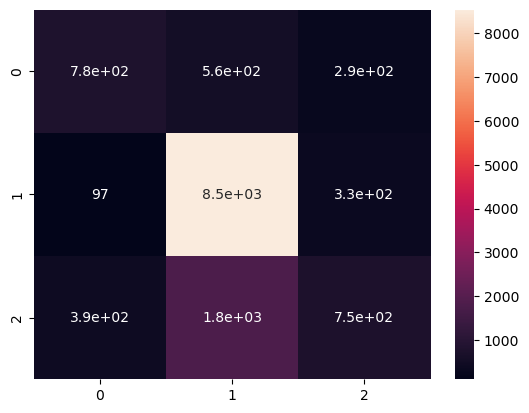

In [ ]:
# DO NOT DELETE
# predict on the model and print confusion matrix
# y_pred_probs = ann_model.predict_model(X_test=X_test_scaled, y_test=y_test)

## Recommendation System

In [501]:
# Generalized Matrix Factorization (GMF)
# GMF-Based Outfit Recommender
class OutfitRecommenderGMF:
    def __init__(self, num_products, num_features, embedding_dim=8, learning_rate=0.001):
        self.num_products = num_products
        self.num_features = num_features
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.model = self.initialize_model()
        
    def initialize_model(self):
        # Inputs
        product_input = Input(shape=(1,), name="Product_Input")
        feature_input = Input(shape=(self.num_features,), name="Feature_Input")

        # Embedding layer for product
        product_embedding = Embedding(input_dim=self.num_products, output_dim=self.embedding_dim, name="Product_Embedding")(product_input)

        product_embedding = Flatten()(product_embedding)

        # Concatenate embeddings and features
        # concatenated = Concatenate()([product_embedding, feature_input])

        # Transform feature input to match embedding size
        transformed_features = Dense(self.embedding_dim, activation='relu')(feature_input)

        # Dot product of the two embeddings
        dot_product = Dot(axes=1)([product_embedding, transformed_features])

        # Dense layer for prediction
        # output = Dense(1, activation="linear", name="Output")(concatenated)
        output = Dense(1, activation="linear", name="Output")(dot_product)

        # Compile the model
        model = Model(inputs=[product_input, feature_input], outputs=output)

        model.summary()

        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss="mse", metrics=["accuracy"])
        return model

    def train(self, product_codes, features, popularity, epochs=100, batch_size=32, verbose=1):
        self.model.fit([product_codes, features], popularity, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

    def predict(self, product_codes, features):
        return self.model.predict([product_codes, features])

    def recommend_outfit(self, product_codes, features, original_df, preference="popular"):
        print(f"inside recommend outfit")
        predictions = self.predict(product_codes, features)
        print(f"predictions: {predictions}")
        
        if preference == "popular":
            recommended_idx = np.argmax(predictions)
        else:  # Alternative, less popular
            recommended_idx = np.argmin(predictions)
        return original_df.iloc[recommended_idx]

In [456]:
# turn epochs to 3
# batch size to None

In [458]:
"""
categorical_features = ['product_group_name', 'index_code']
for feature in categorical_features:
    le = LabelEncoder()
    modeldata_df[feature] = le.fit_transform(modeldata_df[feature])
"""

helper.encode_strings(modeldata_df)

In [465]:
product_codes = modeldata_df["product_code"].values
popularity = modeldata_df["popularity"].values
features = modeldata_df.drop(["popularity", "product_code"], axis=1).values

In [466]:
# standard scaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [467]:
prod_train, prod_test, feat_train, feat_test, pop_train, pop_test = train_test_split(
        product_codes, features, popularity, test_size=0.2, random_state=42)

In [ ]:
"""product_encoder = LabelEncoder()
modeldata_df_copy = modeldata_df
modeldata_df_copy["product_code"] = product_encoder.fit_transform(modeldata_df_copy["product_code"])

product_codes = modeldata_df_copy["product_code"].values

len(product_encoder.classes_)"""

41026

In [ ]:
# len(modeldata_df["product_code"].value_counts().index)

41026

In [468]:
modeldata_df.head()

,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity
0,0,253,1,1010016,9,4,5,1676,0,1,16,1002,1
1,0,253,1,1010016,10,3,9,1676,0,1,16,1002,0
2,0,253,1,1010017,11,1,9,1676,0,1,16,1002,1
8,1,273,2,1010016,9,4,5,3608,1,1,62,1021,0
11,2,252,1,1010001,7,1,12,6515,5,4,44,1002,1


In [469]:
"""
# Number of features after preprocessing
input_dim = X_train_scaled.shape[1]

# Number of classes (low, medium, high)
output_dim = y_train.shape[1]

input_dim, output_dim
"""

'\n# Number of features after preprocessing\ninput_dim = X_train_scaled.shape[1]\n\n# Number of classes (low, medium, high)\noutput_dim = y_train.shape[1]\n\ninput_dim, output_dim\n'

In [ ]:
# prod_train.max()

41024

In [471]:
 # Create and Train the Model
# num_products = len(modeldata_df["product_code"].value_counts().index)

# recommender = OutfitRecommenderGMF(num_products=num_products, num_features=features.shape[1], embedding_dim=1, learning_rate=0.001)
recommender = OutfitRecommenderGMF(num_products=articles_df["product_code"].max() + 1, num_features=features.shape[1], embedding_dim=1, learning_rate=0.001)
recommender.train(prod_train, feat_train, pop_train, epochs=10, batch_size=32)

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Product_Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 Product_Embedding (Embedding)  (None, 1, 1)         959462      ['Product_Input[0][0]']          
                                                                                                  
 Feature_Input (InputLayer)     [(None, 11)]         0           []                               
                                                                                                  
 flatten_19 (Flatten)           (None, 1)            0           ['Product_Embedding[0][0]']      
                                                                                           

## Getting User Input

In [431]:
# Map preferences
preference_mapper = {
    "Popular": 1,
    "Alternative": 2
}

In [472]:
product_group_mapper

{'Garment Upper body': 1,
 'Garment Lower body': 2,
 'Garment Full body': 3,
 'Accessories': 4,
 'Swimwear': 5,
 'Bags': 6}

In [502]:
# ask customer for user input

# give multiple choice
user_outfit_type = int(input("What type of garmet are you looking for? Top: 1, Bottoms: 2, Dress: 3, Accessories: 4, Swimwear: 5, Bags: 6"))

# give multiple choice
user_preference = int(input("Do you want something popular or alternative? Popular: 1, Alternative: 2"))

In [503]:
# Filter Data Based on User Input
filtered_df = modeldata_df[modeldata_df["product_group_name"] == user_outfit_type]
filtered_product_codes = filtered_df["product_code"].values
filtered_features = scaler.transform(filtered_df.drop(["popularity", "product_code"], axis=1).values)

In [504]:
filtered_df[filtered_df["product_code"] == 3957]

,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity


In [505]:
filtered_features

array([[ 0.40754992,  0.81375248,  0.02273934, ..., -0.27144291,
         0.73774624, -0.97670077],
       [ 0.40754992,  0.81375248,  0.02278318, ..., -0.50050582,
        -1.04655229, -1.13593673],
       [ 0.40754992,  0.81375248,  0.02273934, ..., -0.27144291,
         0.44036315, -1.13593673],
       ...,
       [ 0.40754992,  0.81375248,  0.0220817 , ..., -0.50050582,
        -0.9615857 , -0.65822886],
       [ 0.40754992,  0.81375248,  0.02273934, ..., -0.50050582,
        -0.9615857 , -0.65822886],
       [ 0.40754992,  0.81375248,  0.02273934, ..., -0.50050582,
        -0.9615857 , -0.65822886]])

In [506]:
recommended_outfit = recommender.recommend_outfit(filtered_product_codes, filtered_features, modeldata_df, preference=user_preference)
recommended_outfit

416/416 [==============================] - 0s 987us/step


product_code                     3957
product_type_no                   298
product_group_name                  5
graphical_appearance_no       1010016
colour_group_code                  62
perceived_colour_value_id           3
perceived_colour_master_id          6
department_no                    4242
index_code                          1
index_group_no                      1
section_no                         60
garment_group_no                 1018
popularity                          1
Name: 13872, dtype: int64

In [486]:
articles_df[articles_df["product_code"] == recommended_outfit["product_code"]]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc


In [487]:
modeldata_df[modeldata_df["product_code"] == 3957]

,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity
13872,3957,298,5,1010016,62,3,6,4242,1,1,60,1018,1
13873,3957,298,5,1010016,9,4,5,4242,1,1,60,1018,0
13874,3957,298,5,1010016,21,3,8,4242,1,1,60,1018,1
13875,3957,298,5,1010001,71,3,2,4242,1,1,60,1018,1


In [482]:
# need to change it to be the product name from the code
recommended_product_name = articles_df[articles_df["product_code"] == recommended_outfit["product_code"]]["prod_name"].values[0]
recommended_product_name

IndexError: index 0 is out of bounds for axis 0 with size 0

In [481]:
# need to change it to be the product name from the code
recommended_product_name = articles_df[articles_df["product_code"] == recommended_outfit["product_code"]]["prod_name"].values[0]

print(f"Recommended Outfit Based on Your Preference:\nProduct Name: {recommended_product_name}, Product Code: {recommended_outfit['product_code']}")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [437]:
articles_df[articles_df["product_code"] == 566715]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
15377,566715003,566715,Lin Shiny,272,Trousers,Garment Lower body,1010016,Solid,52,Pink,...,Trouser,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1009,Trousers,"Trousers in satin with a detachable tie belt, ..."


### Use ANN Model to recommend outfit

In [395]:
# last ANN step: predict_model (y_pred_probs)
def recommend_outfit(predictions, original_df, preference=preference_mapper["Popular"]):
        if preference == preference_mapper["Popular"]:
            recommended_idx = np.argmax(predictions)
        else:  # Alternative, less popular
            recommended_idx = np.argmin(predictions)
        return original_df.iloc[recommended_idx]

In [403]:
# need to change it to be the product name from the code
recommended_outfit = recommend_outfit(y_pred_probs, modeldata_df, preference=user_preference)
recommended_product_name = articles_df[articles_df["product_code"] == recommended_outfit["product_code"]]["prod_name"].values[0]

print("Recommended Outfit Based on Your Preference:\n", recommended_product_name)

Recommended Outfit Based on Your Preference:
 PQ Lottie cashmere headband
